In [28]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
%pylab inline
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


2D Ising Square-Ice Hamiltonian:
$
H = \sum_p (\sum_{i\in v} \sigma^z_i)^2
$

In [29]:
def plot_configuration(spins):
    '''
    
    this is just a helper function to plot the configuration of spins  given by 'spins'
    note that (i,j) denotes a vertex coordinate.
    
    Parameters
    ----------
    spins  :  int
        spin configuration, dimension is NxNx2
    '''
    N = np.shape(spins)[1]
    fig, ax = plt.subplots()
    fig.add_axes()
    ax = fig.axes[0]
    for i in range(N+1):
        ax.plot([i, i], [0,N], 'k')
        ax.plot([0,N], [i,i], 'k')
    
    colors = ['b', 'gold'] # note: blue is down, red is up!
    for i in range(N):
        fig.gca().add_patch(plt.Circle((i+0.5, N), radius=0.2, fc=colors[int((spins[i,0,0]+1)/2.)]))
        fig.gca().add_patch(plt.Circle((N, i+0.5), radius=0.2, fc=colors[int((spins[0,i,1]+1)/2.)]))
        for j in range(N):
            fig.gca().add_patch(plt.Circle((i+0.5,j), radius=0.2, fc=colors[int((spins[i,j,0]+1)/2.)]))
            fig.gca().add_patch(plt.Circle((i,j+0.5), radius=0.2, fc=colors[int((spins[i,j,1]+1)/2.)]))
    
   
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    fig.show()

In [171]:
# First create training and test configurations with 'create_configurations.py' and rename some to 'test_...'.
configs = np.loadtxt("configs.txt")
labels = np.loadtxt("labels.txt")
N = int(np.sqrt(np.shape(configs[0])[0]/2))
print("loaded %i configurations of size %ix%i for training"%(len(configs), N,N))

loaded 40000 configurations of size 16x16 for training


In [172]:
def total_energy(spins):
    energy = 0
    for i in range(N):
        for j in range(N):
            energy += (spins[i,j,0] + spins[i,j,1] + spins[(i+N-1)%N, j, 0] + spins[i, (j+N-1)%N, 1])**2
    return energy

In [173]:
# checking that all 'T=0' states are indeed ground states
en = 0
for i, config in enumerate(configs):
    if labels[i]==0:
        en += total_energy(np.reshape(config, (N, N, 2)))
print("average energy of the T=0 states: {0}".format(en/len(configs)))

average energy of the T=0 states: 0.0


In [222]:
test_configs = np.loadtxt("test_configs.txt")
test_labels = np.loadtxt("test_labels.txt")
N = int(np.sqrt(np.shape(configs[0])[0]/2))
print("loaded %i test configurations of size %ix%i for training"%(len(test_configs), N,N))

loaded 20000 test configurations of size 16x16 for training


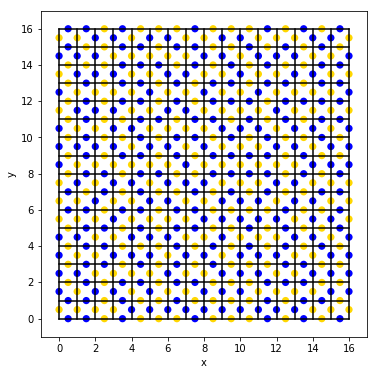

In [175]:
plot_configuration(np.reshape(configs[100], (N, N, 2)))

In [176]:
# prepare data for training
x = configs
y = [((i+1)%2,(i)%2) for i in labels]

In [206]:
hidden_layer = 100
# create model
model = Sequential()
model.add(Dense(hidden_layer, input_dim=N*N*2, kernel_initializer='random_normal', activation='sigmoid', kernel_regularizer=regularizers.l2(0.00005)))
model.add(Dense(2, kernel_initializer='random_normal', activation='softmax', kernel_regularizer=regularizers.l2(0.000005)))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [209]:
model.fit(x, y, epochs=50, batch_size=32,  verbose=0)

In [223]:
test_x = test_configs
test_y = [((i+1)%2,i%2) for i in test_labels]
scores = model.evaluate(test_x, test_y, verbose=0)
print("this model performed with {0}% accuracy".format(scores[1]*100))

this model performed with 99.015% accuracy


Since I chose the L2 regularizer to be rather small, I at least want to make sure my test set is different from my training set.

In [224]:
l1 = len(x)
l2 = len(test_x)
total_set = np.zeros((l1+l2, N*N*2))
total_set[:l1]=x
total_set[l1:]=test_x

In [225]:
# I want to make a set out of the configurations. This is the quickest I could quickly come up with
# (make long int out of bitstring)
def shiftit(x):
    out = 0
    for bit in x:
        out = (out << 1) | int((bit+1)/2)
    return out

z = [shiftit(conf) for conf in total_set]
print("training set consists of {0} configurations, test set of {1}, total overlap is {2}".format(l1, l2, l1+l2 -len(z)))

training set consists of 40000 configurations, test set of 20000, total overlap is 0
